# 1. Install Dependencies and Setup

In [ ]:
!pip install tensorflow opencv-python matplotlib

In [ ]:
!pip list

In [7]:
import tensorflow as tf
import os

In [8]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [9]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [10]:
import cv2
import imghdr

C:\Users\micha\AppData\Local\Temp\ipykernel_8468\4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [11]:
data_dir = 'data' 

In [12]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [13]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [14]:
import numpy as np
from matplotlib import pyplot as plt

In [15]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [16]:
data_iterator = data.as_numpy_iterator()

In [17]:
batch = data_iterator.next()

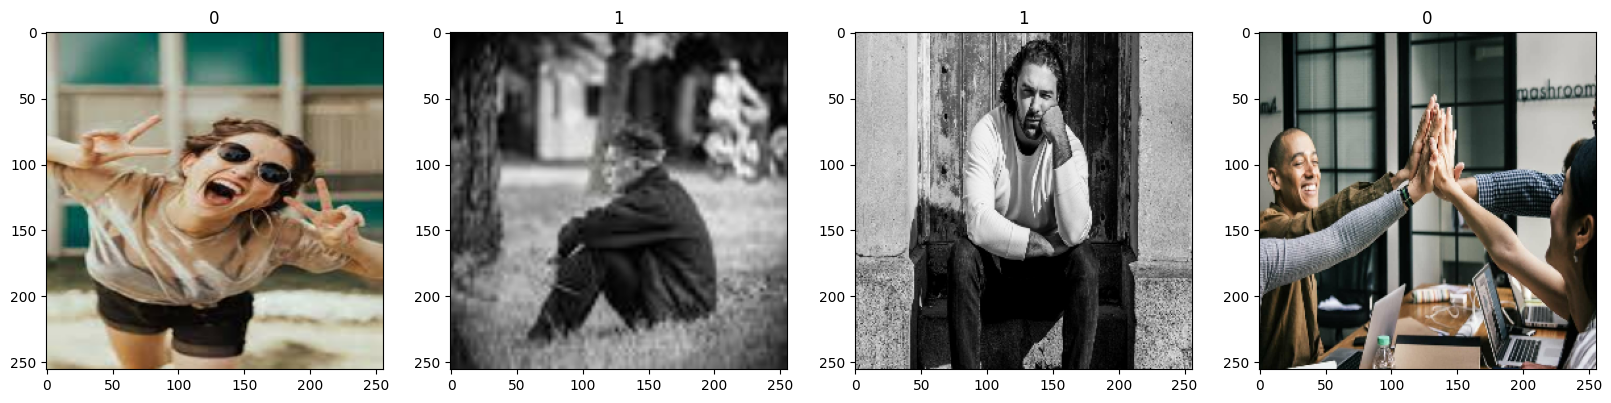

In [18]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [19]:
data = data.map(lambda x,y: (x/255, y))

In [20]:
data.as_numpy_iterator().next()

(array([[[[9.96078432e-01, 9.96078432e-01, 9.96078432e-01],
          [9.96078432e-01, 9.96078432e-01, 9.96078432e-01],
          [9.96078432e-01, 9.96078432e-01, 9.96078432e-01],
          ...,
          [9.96078432e-01, 9.96078432e-01, 9.96078432e-01],
          [9.96078432e-01, 9.96078432e-01, 9.96078432e-01],
          [9.96078432e-01, 9.96078432e-01, 9.96078432e-01]],
 
         [[9.96078432e-01, 9.96078432e-01, 9.96078432e-01],
          [9.96078432e-01, 9.96078432e-01, 9.96078432e-01],
          [9.96078432e-01, 9.96078432e-01, 9.96078432e-01],
          ...,
          [9.96078432e-01, 9.96078432e-01, 9.96078432e-01],
          [9.96078432e-01, 9.96078432e-01, 9.96078432e-01],
          [9.96078432e-01, 9.96078432e-01, 9.96078432e-01]],
 
         [[9.96078432e-01, 9.96078432e-01, 9.96078432e-01],
          [9.96078432e-01, 9.96078432e-01, 9.96078432e-01],
          [9.96078432e-01, 9.96078432e-01, 9.96078432e-01],
          ...,
          [9.96078432e-01, 9.96078432e-01, 9.9607

# 5. Split Data

In [21]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [22]:
train_size

7

In [23]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [24]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [26]:
model = Sequential()

In [27]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [28]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

# 7. Train

In [30]:
logdir='logs'

In [31]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [32]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 7s 729ms/step - loss: 0.8609 - accuracy: 0.5312 - val_loss: 0.6700 - val_accuracy: 0.6719
Epoch 2/20
7/7 [==============================] - 6s 725ms/step - loss: 0.6518 - accuracy: 0.7054 - val_loss: 0.5454 - val_accuracy: 0.7969
Epoch 3/20
7/7 [==============================] - 6s 712ms/step - loss: 0.5622 - accuracy: 0.6964 - val_loss: 0.5556 - val_accuracy: 0.7344
Epoch 4/20
7/7 [==============================] - 6s 726ms/step - loss: 0.4547 - accuracy: 0.8259 - val_loss: 0.2820 - val_accuracy: 0.8906
Epoch 5/20
7/7 [==============================] - 6s 731ms/step - loss: 0.3589 - accuracy: 0.8527 - val_loss: 0.4706 - val_accuracy: 0.7656
Epoch 6/20
7/7 [==============================] - 6s 707ms/step - loss: 0.3671 - accuracy: 0.8170 - val_loss: 0.2912 - val_accuracy: 0.9219
Epoch 7/20
7/7 [==============================] - 7s 788ms/step - loss: 0.2909 - accuracy: 0.9241 - val_loss: 0.2595 - val_accuracy: 0.8906
Epoch 8/20
7/7 [====

# 8. Plot Performance

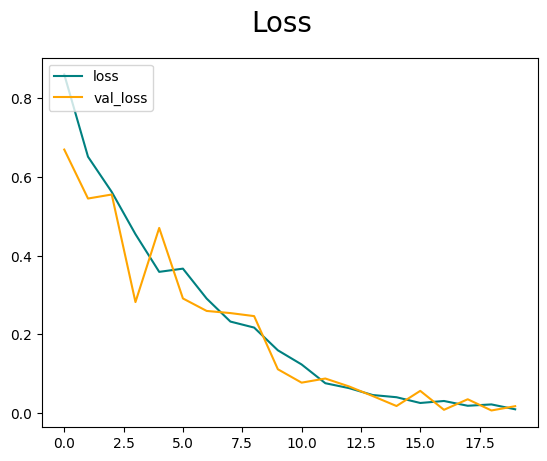

In [33]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

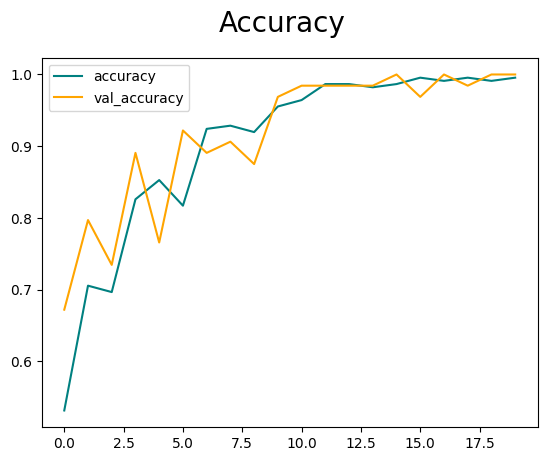

In [34]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [35]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [36]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [37]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 154ms/step


In [38]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [39]:
import cv2

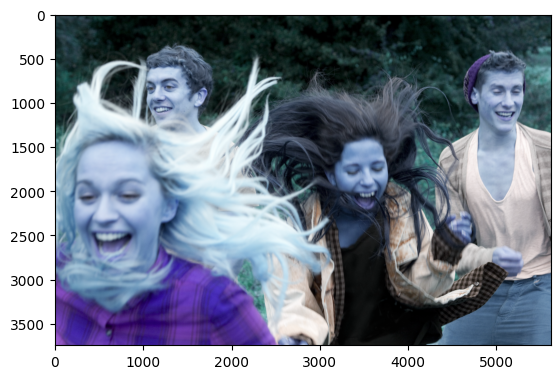

In [40]:
img = cv2.imread('154006829.jpg')
plt.imshow(img)
plt.show()

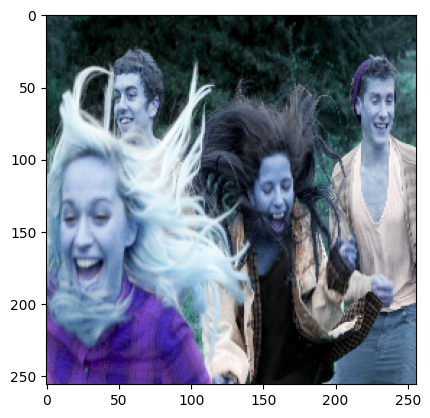

In [41]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [42]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 22ms/step


In [43]:
yhat

array([[0.8834465]], dtype=float32)

In [44]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


# 11. Save the Model

In [45]:
from tensorflow.keras.models import load_model

In [46]:
model.save(os.path.join('models','imageclassifier.h5'))

C:\Users\micha\OneDrive\Documents\GitHub\ImageClassification\imageclassification\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [47]:
new_model = load_model('imageclassifier.h5')

OSError: No file or directory found at imageclassifier.h5

In [47]:
new_model.predict(np.expand_dims(resize/255, 0))

array([[0.01972741]], dtype=float32)